In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import boto3
from botocore.exceptions import ClientError
from IPython.display import Audio
import IPython
from scipy.io import wavfile
from pydub import AudioSegment
import soundfile as sf
from io import BytesIO
from pyAudioAnalysis import audioBasicIO, ShortTermFeatures, MidTermFeatures
import audiosegment

import librosa
import librosa.display
from librosa.core import stft
from librosa.feature import melspectrogram

import PIL

import os

# from src.feature_extraction import vector_merge, call_s3, audio_vectorize
# from src.mels import prep, read_audio, load_audio_windows, show_melspectrogram
from clean_data import process_df
import math

In [2]:
s3_connection = boto3.resource('s3')
s3_client = boto3.client('s3')

In [3]:
bucket_name = 'jarednewstudy'

In [36]:
#using soundfile module
folder = 'audio_test/'
file_name = '26a4977c.wav'
path = folder + file_name

response = s3_client.get_object(Bucket=bucket_name,
                                 Key=path,
                                )

data = BytesIO(response['Body'].read())
sound, samplerate = sf.read(data)
Audio(data=sound, rate=samplerate)

In [37]:
# using AudioSegment module
response = s3_client.get_object(Bucket=bucket_name,
                                 Key=path,
                                )
data = BytesIO(response['Body'].read())
seg = AudioSegment.from_wav(data)

TypeError: title() missing 1 required positional argument: 'label'

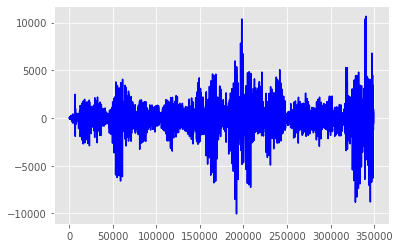

In [38]:
sample_array = seg.get_array_of_samples()
fig, ax = plt.subplots()

plt.plot(sample_array, color='blue')
plt.title()

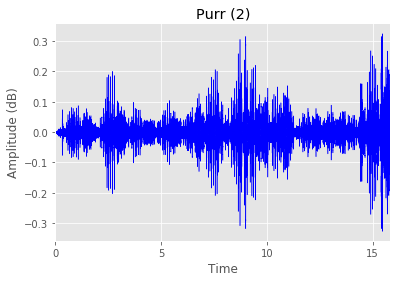

In [39]:
librosa.display.waveplot(sound,color='blue')
plt.title('Purr (2)')
plt.ylabel('Amplitude (dB)')
plt.savefig('img/purr_2.png', dpi=300)

In [7]:
# using audiosegment module (wrapper for AudioSegment)

In [8]:
obj = s3_connection.Object(bucket_name, key=path)
result = obj.get()['Body'].read()
wrapper = BytesIO(result)
wav_ = wavfile.read(wrapper)
seg = audiosegment.from_numpy_array(wav_[1], wav_[0])

Text(0, 0.5, 'Frequency in Hz')

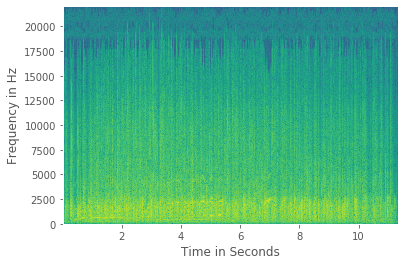

In [9]:
#...
freqs, times, amplitudes = seg.spectrogram(window_length_s=0.03, overlap=0.5)
amplitudes = 10 * np.log10(amplitudes + 1e-9)

# Plot
plt.pcolormesh(times, freqs, amplitudes)
plt.xlabel("Time in Seconds")
plt.ylabel("Frequency in Hz")



Text(0, 0.5, 'energy')

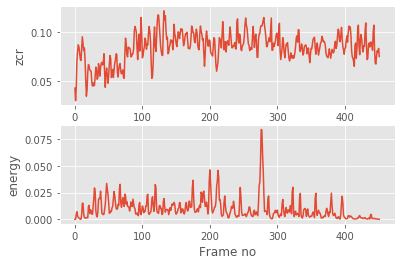

In [10]:
#short term feature extraction example

obj = s3_connection.Object(bucket_name, key=path)
result = obj.get()['Body'].read()
wrapper = BytesIO(result)
wav_ = wavfile.read(wrapper)


Fs, x = wav_[0], wav_[1]
F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.050*Fs, 0.025*Fs)
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0]) 
plt.subplot(2,1,2); plt.plot(F[1,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[1])

In [11]:
print(f_names)

['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std', 'delta zcr', 'delta energy', 'delta energy_entropy', 'delta spectral_centroid', 'delta spectral_spread', 'delta spectral_entropy', 'delta spectral_flux', 'delta spectral_rolloff', 'delta mfcc_1', 'delta mfcc_2', 'delta mfcc_3', 'delta mfcc_4', 'delta mfcc_5', 'delta mfcc_6', 'delta mfcc_7', 'delta mfcc_8', 'delta mfcc_9', 'delta mfcc_10', 'delta mfcc_11', 'delta mfcc_12', 'delta mfcc_13', 'delta chroma_1', 'delta chroma_2', 'delta chroma_3', 'delta chroma_4', 'delta chroma_5', 'delta chroma_6', 'delta chroma_7', 'delta chroma_8', 'delta chroma_9', 'delta chroma_10',

Text(0, 0.5, 'energy_mean')

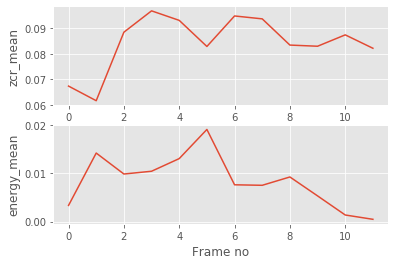

In [12]:
# MidTerm feature extraction example

obj = s3_connection.Object(bucket_name, key=path)
result = obj.get()['Body'].read()
wrapper = BytesIO(result)
wav_ = wavfile.read(wrapper)


Fs, x = wav_[0], wav_[1]
Mid_F, Short_F, mid_f_names = MidTermFeatures.mid_feature_extraction(signal=x,
                                                    sampling_rate=Fs, 
                                                    mid_window=0.5*Fs,
                                                    mid_step =Fs,
                                                    short_window = 0.050*Fs,
                                                    short_step = 0.025*Fs)
plt.subplot(2,1,1); plt.plot(Mid_F[0,:]); plt.xlabel('Frame no'); plt.ylabel(mid_f_names[0]) 
plt.subplot(2,1,2); plt.plot(Mid_F[1,:]); plt.xlabel('Frame no'); plt.ylabel(mid_f_names[1])


In [13]:
individual_df = pd.DataFrame(columns = mid_f_names, data = Mid_F.T)
individual_df.head()

,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,...,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std
0,0.067332,0.003359,2.773907,0.128754,0.152372,0.417435,0.003481,0.086162,-26.823630,0.189446,...,0.026090,0.031952,0.011419,0.005481,0.002277,0.008996,0.004248,0.005871,0.007533,0.008892
1,0.061615,0.014208,3.188429,0.142501,0.164746,0.476475,0.002333,0.092015,-23.780320,-0.081710,...,0.003093,0.002815,0.005641,0.010298,0.022428,0.049669,0.002962,0.004341,0.002571,0.012560
2,0.088407,0.009864,3.074926,0.158046,0.164749,0.815141,0.001709,0.119782,-23.892501,-0.643356,...,0.004663,0.002255,0.003948,0.009909,0.024211,0.002994,0.004337,0.005955,0.003386,0.006227
3,0.096756,0.010438,3.057542,0.164260,0.163711,0.940511,0.001594,0.134301,-23.792328,-0.615604,...,0.003487,0.003264,0.003887,0.004145,0.002967,0.001880,0.003604,0.005280,0.004816,0.001061
4,0.093035,0.013057,3.072687,0.146528,0.151514,0.864442,0.002101,0.109528,-23.714364,-0.586595,...,0.014430,0.004353,0.002823,0.003544,0.002254,0.002911,0.002720,0.002697,0.004156,0.003465


In [14]:
# Each row in F is a different feature for a signal. The columns are time "blocks"... normazlied
# f_names is a list of feature names
len(f_names)

68

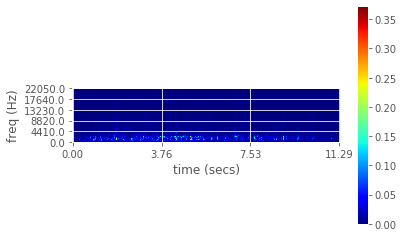

In [15]:
_ = ShortTermFeatures.spectrogram(x, Fs, window=200, step=1000, plot=True)

## Combining the work asbove into iterable functions

At a top level, iteratinging over the S3 bucket,
calling a function on each object that will create and store features into a database.
Need to include a file name as index or column, to allow a join later to labels csv

### see src.feature_extractions.py and clean_data.py

---



## Creating mel spectogram images of files. Account for different lengths. Also exporting sound data as numpy arrays format so no need to import .wav every time

A typical spectrogram uses a linear frequency scaling, so each frequency bin is spaced the equal number of Hertz apart. The mel-frequency scale on the other hand, is a quasi-logarithmic spacing roughly resembling the resolution of the human auditory system.

In [16]:
df = pd.read_csv('data/train_labels.csv')
s3_client = boto3.client('s3')
bucket_name = 'jarednewstudy'
s3_folder = 'audio_train/'
path = '7e8cd849.wav'

## Rolling windows functions

In [17]:
df.tail()

,fname,labels,freesound_id,license
4965,02a5aae7.wav,Bass_drum,360393,CC-BY
4966,9a92f7d0.wav,Bass_drum,360397,CC-BY
4967,3e5a4299.wav,"Shatter,Chink_and_clink",360410,CC-BY-NC
4968,4e5c0a8a.wav,Bark,360411,CC-BY-NC
4969,555fff91.wav,Chink_and_clink,360433,CC-BY


In [18]:
i = 1000

In [19]:
# # finding corrupted file location:
# for idx, fname in enumerate(df['fname']):
#     if fname == '1d44b0bd.wav':
#         print(idx)

In [20]:
fname = df.loc[i,'fname']
label = df.loc[i, 'labels']

In [21]:
#using soundfile module
folder = 'audio_train/'
path = folder + fname

response = s3_client.get_object(Bucket=bucket_name,
                                 Key=path,
                                )

data = BytesIO(response['Body'].read())
sound, samplerate = sf.read(data)
print(label)
Audio(data=sound, rate=samplerate)


Accordion


## Iterating over labels dataframe,  testing process pipeline

In [22]:
train_path = 'data/train_labels.csv'

In [23]:
df = process_df(train_path)

In [24]:
df.head()

,fname,labels
0,ac9e7a91.wav,Church_bell
1,65ae847e.wav,Frying_(food)
2,32ec2454.wav,Computer_keyboard
3,af7b5bab.wav,Scissors
4,7e8cd849.wav,Purr


In [78]:
from src.mels import prep, read_audio, show_melspectrogram

In [53]:
from src.mels import load_audio_windows, mel_windowed

In [69]:
batch = 20
path = 'data/train_labels.csv'
s3_client = boto3.client('s3')
bucket_name = 'jarednewstudy'
s3_folder = 'audio_test/'
trim_long_data=False
fname = '26a4977c.wav'
label = 'purr'

In [70]:
windows = load_audio_windows(prep, label, fname, s3_client, bucket_name, s3_folder, trim_long_data)

/Users/jared/anaconda3/lib/python3.7/site-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


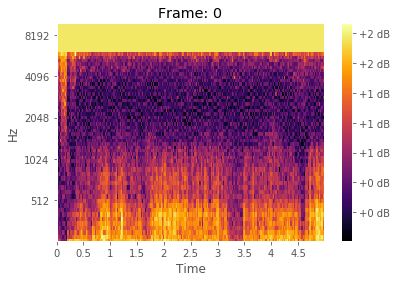

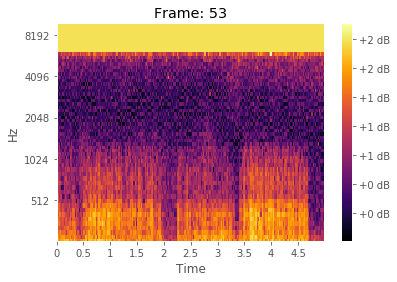

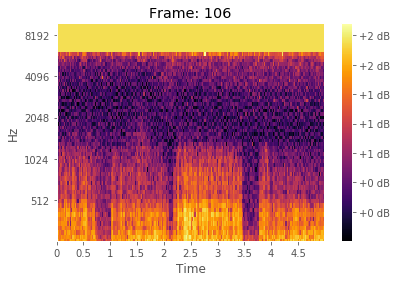

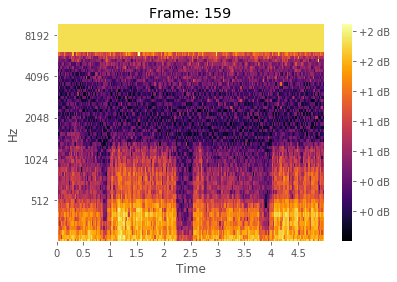

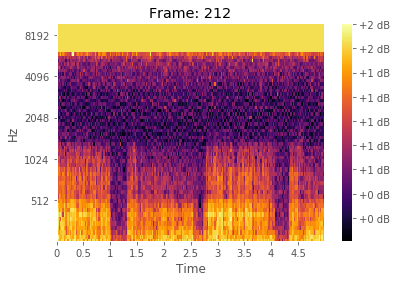

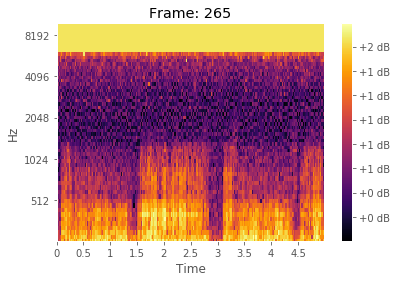

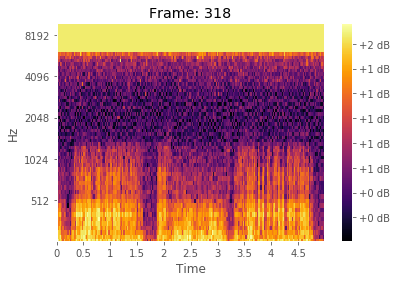

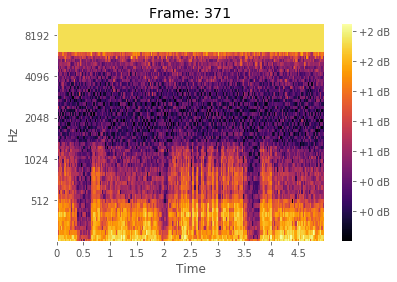

In [115]:
window_size = int(prep.window_size)
window_hop = int(prep.window_hop)
#truncation method
start_frame = window_size
end_frame = mels.shape[1] - window_hop 
windows = []
for frame_idx in range(start_frame, end_frame, window_hop):
    # grab a slice of the spectogram at once
    win = (mels[:, frame_idx-window_size:frame_idx])
    #normalize within frame
    # win = librosa.core.power_to_db(win, top_db=80)
    win = np.log(win + 1e-9) 
    win -= np.mean(win)
    win /= np.std(win)
    show_melspectrogram(prep,win, title="Frame: {}".format(frame_idx-window_size), cmap='inferno',i=frame_idx)
# plt.savefig('img/mel_win{}.png'.format(frame_idx), dpi=256)

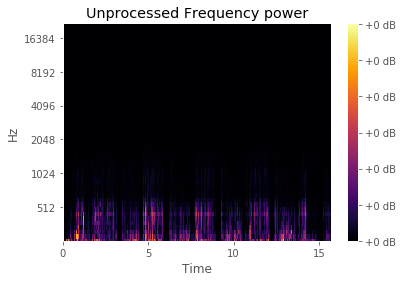

In [104]:
show_melspectrogram(prep,mels, title='Unprocessed Frequency power', cmap='inferno',i='original')

In [102]:
mels2 = abs(mels)
mels2 = np.log(mels2 + 1e-9) 

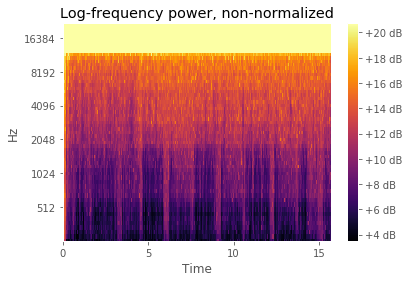

In [103]:
show_melspectrogram(prep,abs(mels2), title='Log-frequency power, non-normalized', cmap='inferno',i='abs')

In [95]:
mels3 = mels2 - np.mean(mels2)
mels3 /= np.std(mels3)

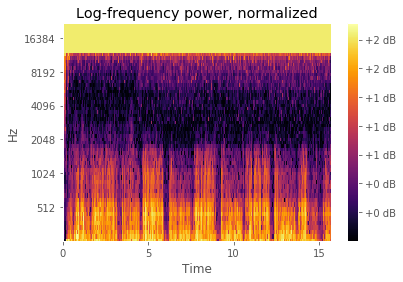

In [96]:
show_melspectrogram(prep,abs(mels3), title='Log-frequency power, normalized', cmap='inferno',i='norm')

In [116]:
mels = melspectrogram(y=y, sr=sr, S=S,
                        n_mels=prep.n_mels, fmin=prep.fmin, fmax=prep.fmax)

/Users/jared/anaconda3/lib/python3.7/site-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


In [31]:
train_out = 'data/train_windows_mel.csv'

In [32]:
mvdf = pd.read_csv(train_out, index_col=0)

In [33]:
mvdf

,0,1,2,3,4,5,6,7,8,9,...,12891,12892,12893,12894,12895,12896,12897,12898,12899,labels
ac9e7a91.wav,(0.8720727-0.55586475j),(0.97243+0.47310236j),(1.1108465-0.5037104j),(0.9333715-0.46517918j),(1.0634736-0.47932836j),(1.1580651+0.045449547j),(1.1319557+0.5294742j),(1.1067612-0.18195131j),(1.1150475+0.105091475j),(1.0884783+0.49223566j),...,(-1.7656741+0.0027507467j),(-1.7656741+0.0027507467j),(-1.7656741+0.0027507467j),(-1.7656741+0.0027507467j),(-1.7656741+0.0027507467j),(-1.7656741+0.0027507467j),(-1.7656741+0.0027507467j),(-1.7656741+0.0027507467j),(-1.7656741+0.0027507467j),Church_bell
ac9e7a91.wav,(1.1620889-0.40256172j),(0.8195885+0.22436227j),(1.1583741+0.18477306j),(0.92741376-0.30937093j),(1.1496263-0.34877148j),(0.9815187+0.3381944j),(0.78291595+0.53184026j),(1.0595443-0.21048172j),(1.0112655-0.4128221j),(1.0171237+0.21520227j),...,(-1.7668371+0.001747158j),(-1.7668371+0.001747158j),(-1.7668371+0.001747158j),(-1.7668371+0.001747158j),(-1.7668371+0.001747158j),(-1.7668371+0.001747158j),(-1.7668371+0.001747158j),(-1.7668371+0.001747158j),(-1.7668371+0.001747158j),Church_bell
ac9e7a91.wav,(1.0819808-0.38528323j),(0.89443386-0.37575608j),(0.8043155+0.07030975j),(1.1942259-0.12525356j),(1.2379514+0.26573363j),(1.0011575-0.5430332j),(0.88896024+0.033864737j),(0.92523164-0.02095847j),(0.95133233-0.5035442j),(1.0703399+0.05758296j),...,(-1.7560852-0.00046687393j),(-1.7560852-0.00046687393j),(-1.7560852-0.00046687393j),(-1.7560852-0.00046687393j),(-1.7560852-0.00046687393j),(-1.7560852-0.00046687393j),(-1.7560852-0.00046687393j),(-1.7560852-0.00046687393j),(-1.7560852-0.00046687393j),Church_bell
ac9e7a91.wav,(1.1904478-0.13529912j),(0.56683093-0.3350452j),(1.1070894+0.41009906j),(1.0396317+0.028394233j),(1.0836594-0.3218837j),(0.86174834+0.39389622j),(1.0672377+0.19966662j),(1.067286-0.15885366j),(1.0418937+0.3230034j),(1.0345826+0.2587691j),...,(-1.7456528+0.0003073491j),(-1.7456528+0.0003073491j),(-1.7456528+0.0003073491j),(-1.7456528+0.0003073491j),(-1.7456528+0.0003073491j),(-1.7456528+0.0003073491j),(-1.7456528+0.0003073491j),(-1.7456528+0.0003073491j),(-1.7456528+0.0003073491j),Church_bell
65ae847e.wav,(0.28678146+0.001967726j),(0.46207947+0.16326383j),(0.5549207+0.58711433j),(0.48897272-0.24187677j),(0.4599209+0.25361636j),(0.5127542-0.56587243j),(0.5938512-0.25957084j),(0.5694763+0.13295428j),(0.5385659+0.62069625j),(0.58470094-0.2750396j),...,(-2.0571358+0.001967726j),(-2.0571358+0.001967726j),(-2.0571358+0.001967726j),(-2.0571358+0.001967726j),(-2.0571358+0.001967726j),(-2.0571358+0.001967726j),(-2.0571358+0.001967726j),(-2.0571358+0.001967726j),(-2.0571358+0.001967726j),Frying_(food)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f834cdd3.wav,(1.7323799-0.25421652j),(1.8228402+0.05015914j),(1.8654784+0.5037285j),(1.9345784+0.68976486j),(1.9349957-0.6131809j),(1.7763901-0.24082197j),(1.8589745-0.1731026j),(1.9181304+0.05501819j),(1.7724702+0.1810928j),(1.8497918+0.54003173j),...,(-1.7008615+0.00143437j),(-1.7008615+0.00143437j),(-1.7008615+0.00143437j),(-1.7008615+0.00143437j),(-1.7008615+0.00143437j),(-1.7008615+0.00143437j),(-1.7008615+0.00143437j),(-1.7008615+0.00143437j),(-1.7008615+0.00143437j),Chewing_and_mastication
7ea9dcb5.wav,(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),...,(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),(-0.6479569-0.00024074248j),Scissors
7ea9dcb5.wav,(-0.95342875-0.0029089188j),(-0.95342875-0.0029089188j),(-0.95342875-0.0029089188j),(-0.95342875-0.0029089188j),(-0.95342875-0.0029089188j),(-0.95342875-0.0029089188j),(-0.95342875-0.0029089188j),(

In [72]:
test_labels = pd.read_csv('data/test_labels.csv')

In [73]:
test_labels.head()

,fname,labels,usage,freesound_id,license
0,d527f12d.wav,Chewing_and_mastication,Private,327681,CC-BY-NC
1,4030a4f2.wav,Cupboard_open_or_close,Public,180226,CC-BY
2,e106401c.wav,Purr,Private,155651,CC0
3,8d22f633.wav,Waves_and_surf,Private,360450,CC0
4,2d5dcc5d.wav,"Tap,Drawer_open_or_close",Public,245765,CC0


In [120]:
test_labels['labels'].unique()

array(['Chewing_and_mastication', 'Cupboard_open_or_close', 'Purr',
       'Waves_and_surf', 'Tap,Drawer_open_or_close', 'Church_bell',
       'Zipper_(clothing)', 'Writing', 'Hiss,Crackle', 'Screaming',
       'Gasp', 'Cricket', 'Sigh', 'Gong', 'Crackle', 'Skateboard',
       'Stream', 'Car_passing_by,Race_car_and_auto_racing',
       'Cutlery_and_silverware,Chink_and_clink', 'Finger_snapping',
       'Knock,Clapping', 'Male_singing', 'Shatter', 'Mechanical_fan',
       'Male_speech_and_man_speaking,Female_singing,Finger_snapping',
       'Keys_jangling', 'Sink_(filling_or_washing),Gurgling',
       'Chewing_and_mastication,Chirp_and_tweet,Traffic_noise_and_roadway_noise,Child_speech_and_kid_speaking',
       'Tap,Chirp_and_tweet,Waves_and_surf', 'Scissors',
       'Walk_and_footsteps,Run', 'Marimba_and_xylophone',
       'Male_speech_and_man_speaking,Squeak,Crackle',
       'Burping_and_eructation',
       'Cricket,Traffic_noise_and_roadway_noise', 'Shatter,Knock',
       'Applause,K

In [74]:
target = 'Purr'
test_majority = test_labels[test_labels['labels'] != target]
test_minority = test_labels[test_labels['labels'] == target]

In [75]:
sum(test_majority['labels'].value_counts())

4432

In [76]:
sum(test_minority['labels'].value_counts())

49

In [77]:
not_purr_df = test_majority.sample(52, replace=False)

In [78]:
eq_df = pd.concat([not_purr_df, test_minority], axis=0)

In [79]:
eq_df.head()

,fname,labels,usage,freesound_id,license
2316,10e6db66.wav,Burping_and_eructation,Public,110658,CC-BY-NC
1753,d9aed7c4.wav,Glockenspiel,Private,396287,CC0
860,a565013d.wav,Bus,Private,165281,CC-BY
1029,27ce0e90.wav,Chewing_and_mastication,Public,403191,CC-BY
2396,518ee662.wav,"Walk_and_footsteps,Tap,Zipper_(clothing)",Private,422145,CC0


In [80]:
eq_df = eq_df.sample(frac=1).reset_index(drop=True)
eq_df.head(15)

,fname,labels,usage,freesound_id,license
0,340da762.wav,Purr,Public,254080,CC0
1,2d21dbf4.wav,Purr,Public,326296,CC0
2,26a4977c.wav,Purr,Public,401825,CC0
3,894cb6cb.wav,Glockenspiel,Private,11072,CC0
4,10e6db66.wav,Burping_and_eructation,Public,110658,CC-BY-NC
5,86ef9b31.wav,Purr,Private,31540,CC Sampling+
6,667de40c.wav,Purr,Private,366407,CC-BY-NC
7,83ad2605.wav,"Sink_(filling_or_washing),Water_tap_and_faucet",Private,85682,CC0
8,6b5abad8.wav,Tick-tock,Private,110573,CC Sampling+
9,7d47be15.wav,Purr,Private,137894,CC-BY


In [81]:
eq_df.shape

(101, 5)

In [82]:
eq_df.to_csv('data/test_balanced.csv')

In [84]:
for row in eq_df.iloc[:10,:].iterrows():
        print(" ", row[1][0])

  340da762.wav
  2d21dbf4.wav
  26a4977c.wav
  894cb6cb.wav
  10e6db66.wav
  86ef9b31.wav
  667de40c.wav
  83ad2605.wav
  6b5abad8.wav
  7d47be15.wav


In [87]:
tt = pd.read_csv('data/test_balanced.csv', index_col=0)

In [88]:
tt.head()

,fname,labels,usage,freesound_id,license
0,340da762.wav,Purr,Public,254080,CC0
1,2d21dbf4.wav,Purr,Public,326296,CC0
2,26a4977c.wav,Purr,Public,401825,CC0
3,894cb6cb.wav,Glockenspiel,Private,11072,CC0
4,10e6db66.wav,Burping_and_eructation,Public,110658,CC-BY-NC
